# EXp4, spatioanl organization in a single-species population



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()
from BioMi_function_collection import *
import sys 
import pandas as pd

# Time stepping

In [2]:
def func_timestepping():
    """
    Runs timestepping, but needs everything to have already been defined previously in the settings cell.
    
    Has discrete death (through demographics)
    """

    #--- time loop ----
    for t in range(ntim):


        #--- size loop ---
        for l in range(nsiz):

            
            #--- Object birthdays! Time-shift of the demographics levels ---
            for i in range(nage-1,0,-1):
                N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten
            
            
            #--- Probability of birth p ---
            if pulse_growth_flag:
                
                dp_pulse[:,:] = 0.

                #--- Adjust p under certain rules ---
                
                # Rule 1: pulsating growth
                for i in range(len(x)):
                    for j in range(len(y)):
                        xr = np.array( range(i-nx_pulse,i+nx_pulse+1) )
                        xr = np.where(xr < 0  , xr+nx, xr)
                        xr = np.where(xr >= nx, xr-nx, xr)
                        yr = np.array( range(j-ny_pulse,j+ny_pulse+1) )
                        yr = np.where(yr < 0  , yr+ny, yr)
                        yr = np.where(yr >= ny, yr-ny, yr)
                        submesh = np.ix_( xr, yr )
                        #print( submesh)
                        dp_pulse[submesh] = dp_pulse[submesh] + f_pulse[:,:] * np.sum(N[i,j,l,t,:])
                    

                p[:,:,l,t] = p[:,:,l,t] + prob_sub * dp_pulse[:,:] * fac_pulse

                # Rule 2: environmental deformation, so that average birth rate is conserved at prob_sub
                if np.mean(p[:,:,l,t])>0.:
                    #print( np.mean(p[:,:,l,t]) )
                    fac_p = prob_sub / np.mean(p[:,:,l,t])
                    p[:,:,l,t] = p[:,:,l,t] * fac_p


            #--- Births ---
            B = np.random.binomial(N_tot_ref[l], p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally

            
            #--- Update object number ---
            N[:,:,l,t,0] = B    # add births as level 1 demographics
            
            
            print( "t=%s  time = %s" % (t, t*dtim),' sizebin' ,l,'max birth: ',np.max(B),np.max(N[:,:,l,t,0]))

        
    return N, p, dp_pulse


# Settings  and initialization

In [3]:


#--- Grid parameters ----------
nx   = 100     #grid size
ny   = 100
nsiz = 1       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
#ntim = 12*60    #nr of timesteps  12 hours
ntim = 24*60    #nr of timesteps  12 hours
ntim = 200    #nr of timesteps  12 hours

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 100.    #x gridspacing     [m]
dy   = 100.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]

#--- Reference domain
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)
B_0[:]    = 2.e-7   #average nr of object births / m2 / s

tau_D     = 300.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata

#--- pulsating growth parameters
pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
#fac_pulse =   40.    #factor of proportionality in impact of pulsating growth on p
fac_pulse = 2000.    

#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability
dp_pulse = np.empty( (nx,ny) )    #perturbation in p due to pulsating growth (rule 1)


#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p[:,:,:,:] = prob_sub

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
#--- set up pulsating growth stuff ---   
print(pulse_growth_flag)

if pulse_growth_flag:
    nx_pulse = np.int( r_pulse / dx)
    ny_pulse = np.int( r_pulse / dy)

    f_pulse  = np.empty( (2 * nx_pulse + 1, 2 * ny_pulse + 1) )  

    for i in range(f_pulse.shape[0]):
        for j in range(f_pulse.shape[0]):
            f_pulse[i,j] = np.max( [0., 1. - ( (dx * (i - nx_pulse))**2 + (dy * (j - ny_pulse))**2 )**0.5 / r_pulse ] )
            

#Setting the seed so things are always the same
np.random.seed(1)

prob_sub=1e-08
size=50.0 B0=2e-07 N_tot_ref=11999999.0
1


# Now the fun starts!

In [4]:
N, p, dp_pulse = func_timestepping()

t=0  time = 0.0  sizebin 0 max birth:  3 3
t=1  time = 60.0  sizebin 0 max birth:  3 3
t=2  time = 120.0  sizebin 0 max birth:  3 3
t=3  time = 180.0  sizebin 0 max birth:  4 4
t=4  time = 240.0  sizebin 0 max birth:  3 3
t=5  time = 300.0  sizebin 0 max birth:  3 3
t=6  time = 360.0  sizebin 0 max birth:  4 4
t=7  time = 420.0  sizebin 0 max birth:  3 3
t=8  time = 480.0  sizebin 0 max birth:  3 3
t=9  time = 540.0  sizebin 0 max birth:  3 3
t=10  time = 600.0  sizebin 0 max birth:  3 3
t=11  time = 660.0  sizebin 0 max birth:  3 3
t=12  time = 720.0  sizebin 0 max birth:  4 4
t=13  time = 780.0  sizebin 0 max birth:  4 4
t=14  time = 840.0  sizebin 0 max birth:  4 4
t=15  time = 900.0  sizebin 0 max birth:  3 3
t=16  time = 960.0  sizebin 0 max birth:  3 3
t=17  time = 1020.0  sizebin 0 max birth:  3 3
t=18  time = 1080.0  sizebin 0 max birth:  3 3
t=19  time = 1140.0  sizebin 0 max birth:  4 4
t=20  time = 1200.0  sizebin 0 max birth:  3 3
t=21  time = 1260.0  sizebin 0 max birth:  

## Save N field to netcdf file

In [114]:
import datetime

fnameout = "N_thermals.nc"

out = Dataset(fnameout, 'w', format='NETCDF4')
print("writing to file: " + fnameout)


out.creator     = "Roel Neggers, IGMK, University of Cologne"
out.created     = datetime.datetime.today().strftime('%d %b %Y')


xdim    = out.createDimension('nx'    , nx)
ydim    = out.createDimension('ny'    , ny)
sizdim  = out.createDimension('nsiz'  , nsiz)
timdim  = out.createDimension('ntim'  , ntim)
agedim  = out.createDimension('nage'  , nage)


out_x = out.createVariable('x', np.float32, ('nx'))
out_x.units = 'm'
out_x.long_name = 'gridsize in x direction'

out_y = out.createVariable('y', np.float32, ('ny'))
out_y.units = 'm'
out_y.long_name = 'gridsize in y direction'

out_siz = out.createVariable('siz', np.float32, ('nsiz'))
out_siz.units = 'm'
out_siz.long_name = 'object size'

out_tim = out.createVariable('time', np.float32, ('ntim'))
out_tim.units = 's'
out_tim.long_name = 'time'

out_age = out.createVariable('age', np.int32, ('nage'))
out_age.units = 'index'
out_age.long_name = 'age stratum'


out_N  = out.createVariable('N', np.int32, ('nx','ny','nsiz','ntim','nage'))
out_N.units = 'count'
out_N.long_name = 'object number'

out_x  [:] = x
out_y  [:] = y
out_siz[:] = siz
out_tim[:] = tim
out_age[:] = range(nage)

out_N[:,:,:,:,:] = N[:,:,:,:,:]

out.close()


writing to file: N_thermals.nc


## 2D scatter plot

Text(0.5, 0, 'y [km]')

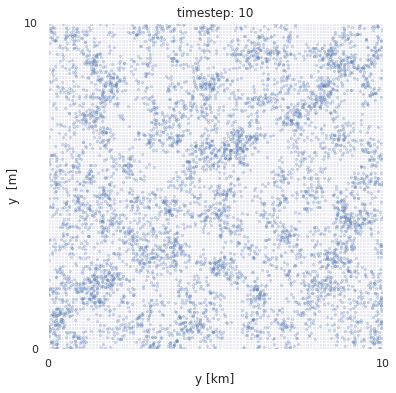

In [115]:

fig = plot_scatter_time(N,10,dx=dx,dy=dy,figsize=(6,6),color=['b'],sizes=[5],buffer=[0.97],alpha=[0.2])
axes =plt.gca()

#Hacking the correct ticks and labels in
labels = axes.get_xticklabels()
nxlab = len(labels)
xlab = np.empty( (nxlab) ).astype(np.str)
xlab[:] = ''
xlab[1      ] = '0'
xlab[-2] = '10'
axes.set_xticklabels(xlab)
axes.set_yticklabels(xlab)

axes.set_xlabel('x [km]')
axes.set_xlabel('y [km]')

## Video maker


In [70]:
#Slighty modified version of the standard movie making function to get the right labels 


def plot_scatter_movie(N,t0,t1,output_folder='mov/',base_str='N_movie_',name='',dpi=200,
    sizes         = [1,10,20,50,90],
    color         = ['k','b','orange','r','g'],
    buffer        = [0.9,0.85,0.8,0.75,0.7],
    alpha         = [0.5,0.5,0.5,0.5,0.5],
    figsize       = (6,6),
    time_tracking = True,
    t_substeps    = 10,
    dx=1,dy=1,
    rotation=0):
    """
    A wrapper for plot_scatter_time that loops from t0 to t1 plotting the scatter plots for each and saving them.
    
    Currently only works for up to 5 different objects
    WARNNG: Seems to have a memory leak! Don't run forever.
    """
    
    for t in range(t0,t1): 
        fig = plot_scatter_time(N,t,
        sizes         = sizes     ,
        color         = color     ,
        buffer        = buffer    ,
        alpha         = alpha     ,
        figsize       = figsize   ,
        time_tracking = time_tracking,
        t_substeps    = t_substeps,
        dx = dx, dy =dy,
        rotation = rotation)
        
        axes =plt.gca()
        #Hacking the correct ticks and labels in
        labels = axes.get_xticklabels()
        nxlab = len(labels)
        xlab = np.empty( (nxlab) ).astype(np.str)
        xlab[:] = ''
        xlab[1      ] = '0'
        xlab[-2] = '10'
        axes.set_xticklabels(xlab)
        axes.set_yticklabels(xlab)
        axes.set_xlabel('x [km]')
        axes.set_ylabel('y [km]')
        
        
        ext = ".png"
        savestring =base_str+name+'_dt'+str(t)+ext
        if t<100:
            savestring =base_str+name+'_dt0'+str(t)+ext
        if t<10:
            savestring =base_str+name+'_dt00'+str(t)+ext

        fig.savefig(output_folder+savestring,bbox_inches = 'tight',dpi=200)
        print('saved: '+output_folder+savestring)
        plt.close(fig)
        
        
    
    return


In [71]:
#Makes and saves individual png of the timesteps to be made into a movie later on. 
plot_scatter_movie(N,0,10,name='cluster',dx=dx,dy=dy,figsize=(6,6),color=['b'],sizes=[5],buffer=[0.97],alpha=[0.2])


saved: mov/N_movie_cluster_dt000.png
saved: mov/N_movie_cluster_dt001.png
saved: mov/N_movie_cluster_dt002.png
saved: mov/N_movie_cluster_dt003.png
saved: mov/N_movie_cluster_dt004.png
saved: mov/N_movie_cluster_dt005.png
saved: mov/N_movie_cluster_dt006.png
saved: mov/N_movie_cluster_dt007.png
saved: mov/N_movie_cluster_dt008.png
saved: mov/N_movie_cluster_dt009.png


# Clustering



In [7]:
#l=0
l=nsiz-1

#Specific time point to save 2D fields
ntim2 = 5


#Set N-threshold for clustering
N_crit = 1
#N_crit = 2

Npixel_largest = np.array(range(ntim))
Ntot           = np.array(range(ntim))
Ntot_lab       = np.array(range(ntim))

nbin = 39
sd_size_lin = np.empty((ntim,nbin))
sd_N_lin    = np.empty((ntim,nbin))

print('start clustering...')

for t in range(1,ntim):

    #Making a 2D binary field and clustering it with periodic boundary conditions
    N_final = np.sum( N[:,:,l,t,:], axis=2)
    binary_N = np.zeros_like(N_final)

    binary_N[N_final>N_crit] = 1

    labeled_N = cluster_2D(binary_N,buffer_size=20)
    
    if t==ntim2:
        binary_N_ntim2  = binary_N
        labeled_N_ntim2 = labeled_N     #store timepoint of interest

    labels, pixels = np.unique(labeled_N.ravel(),return_counts=True)
    
    if (np.size(pixels[1:])>0):
        Npixel_largest[t] = np.max(pixels[1:])
        Ntot          [t] = np.sum(N[:,:,l,t,:])
        Ntot_lab      [t] = np.sum(binary_N[:,:])

    #print( "  t=%s  time = %s" % (t, t*dtim), 'pixels of largest cluster: ',max(pixels[1:]))

    #-- size sorting --
    bins_lin2, ind_lin2, CSD_lin2 = lin_binner_minmax(pixels[1:] ,1,nbin+1,nbin)
    #print( (t,len(bins_lin2),len(CSD_lin2),len(sd_size_lin[t,:]))) 

    sd_size_lin[t,:] = np.sqrt(bins_lin2[1:])
    sd_N_lin   [t,:] = CSD_lin2
    
print('done')



start clustering...
done


# Convective memory

Timeseries of the number of pixels in the largest cluster on the grid, different experiments yield different time-series. However, what they all share is a gradual increase in max cluster size.



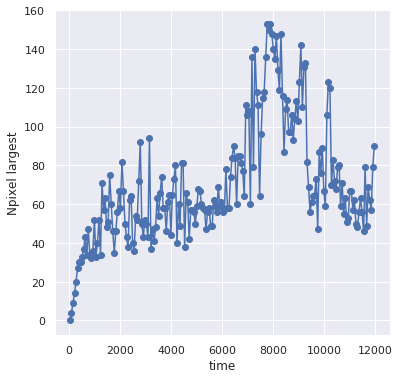

In [8]:
fig = plt.figure(figsize=(6,6))

plt.plot(tim,Npixel_largest,'o-')
plt.xlabel('time')
plt.ylabel('Npixel largest')

plt.show()

ext = ".pdf"

savestring ='largest_cluster_over_time.pdf'


# For comparison: Total number of objects on the grid 

Quickly equilibrates, should be equal to B0. 

Expresses balance between grid-average birth and death rates.

Note: Rule 2 ensures this is the case, by making the cluster-environment more hostile for object births in such a way that grid-average p is conserved.

So this is not the same as convective memory, it expresses the constraint on B0 we impose.


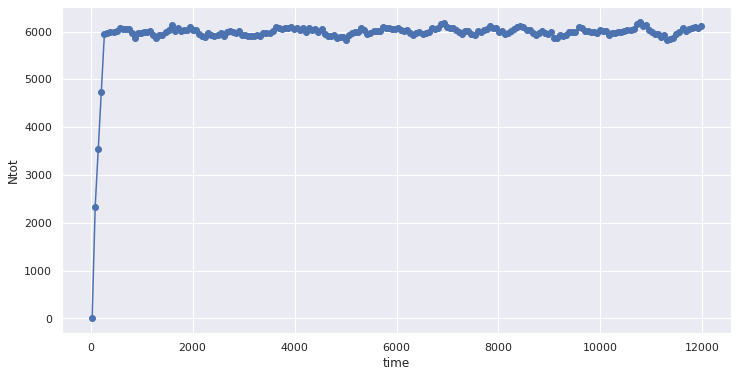

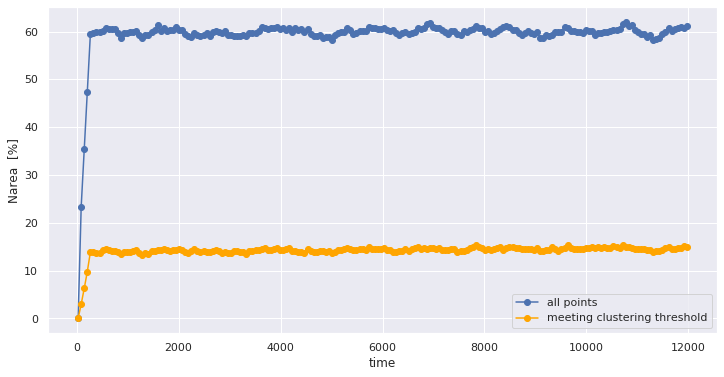

In [9]:
fig = plt.figure(figsize=(12,6))
plt.plot(tim,Ntot,'o-')
plt.xlabel('time')
plt.ylabel('Ntot')

plt.show() 


Narea     = 100. * Ntot    [:].astype(np.float) / (nx*ny)
Narea_lab = 100. * Ntot_lab[:].astype(np.float) / (nx*ny)
#print(Narea)

fig = plt.figure(figsize=(12,6))
plt.plot(tim,Narea    ,'o-',label='all points')
plt.plot(tim,Narea_lab,'o-',color='orange',label='meeting clustering threshold')

plt.xlabel('time')
plt.ylabel('Narea  [%]')

plt.legend()


## Cluster plot of a specific timepoint


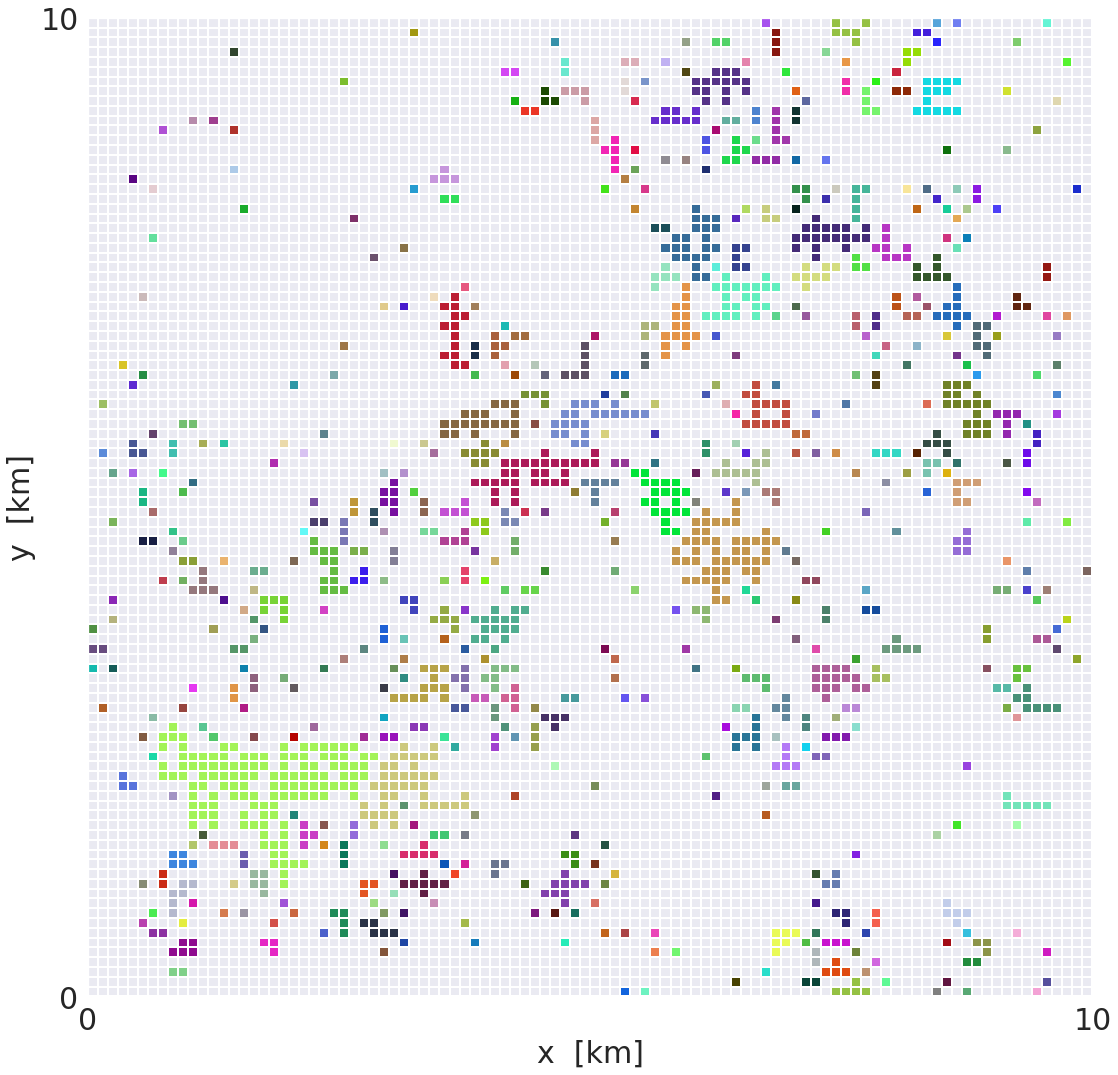

In [10]:
#Gigantic plot because I can't get the pcolormesh plot to have the right linewidth otherwise

t= 150
l = 0
#Summing over all ages
N_final = np.sum( N[:,:,l,t,:], axis=2)

#Making it a binary 1 where more than the critical amount are
binary_N = np.zeros_like(N_final)
binary_N[N_final>N_crit] = 1

#Label and mask out
labeled_N = cluster_2D(binary_N,buffer_size=20)
masked_N = np.ma.masked_where(labeled_N<1,labeled_N)

#plot
fig,axes = plt.subplots(1,1,figsize=(18,18))
plt.pcolormesh(masked_N,cmap=func_generate_random_cmap(),rasterized=True,edgecolor='w')


plt.xlabel("%s  [%s]" % ("x","km"),fontsize=30)
plt.ylabel("%s  [%s]" % ("y","km"),fontsize=30)
axes.set_xticks([0,nx])
axes.set_yticks([0,ny])
axes.set_xticklabels([0,10],fontsize=30)
axes.set_yticklabels([0,10],fontsize=30)

plt.show()                         # Show the figure





In [11]:
fig.savefig('fig/0615_example.pdf',bbox_inches='tight')

# loading and plotting a single timestep

In [12]:
inpu = Dataset('N_thermals_1079.nc')

In [15]:
N = inpu.variables['N'][:]

In [18]:
N.shape


(100, 100, 1, 5)

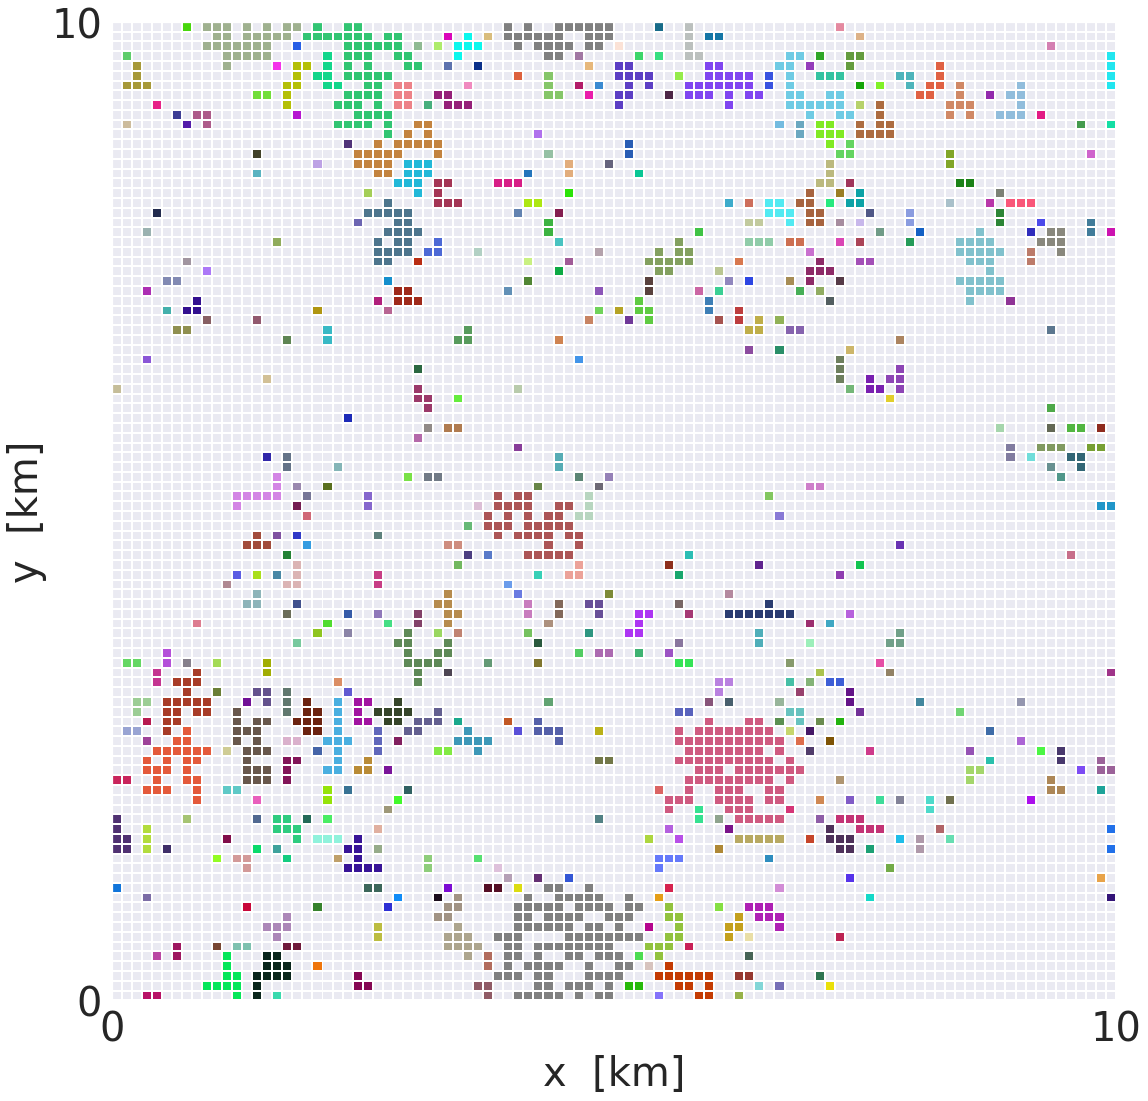

In [23]:
#Gigantic plot because I can't get the pcolormesh plot to have the right linewidth otherwise

l = 0
#Summing over all ages
N_final = np.sum( N[:,:,l,:], axis=2)

#Making it a binary 1 where more than the critical amount are
binary_N = np.zeros_like(N_final)
binary_N[N_final>N_crit] = 1

#Label and mask out
labeled_N = cluster_2D(binary_N,buffer_size=20)
masked_N = np.ma.masked_where(labeled_N<1,labeled_N)

#plot
fig,axes = plt.subplots(1,1,figsize=(18,18))
plt.pcolormesh(masked_N,cmap=func_generate_random_cmap(10000),rasterized=True,edgecolor='w')


plt.xlabel("%s  [%s]" % ("x","km"),fontsize=40)
plt.ylabel("%s  [%s]" % ("y","km"),fontsize=40)
axes.set_xticks([0,nx])
axes.set_yticks([0,ny])
axes.set_xticklabels([0,10],fontsize=40)
axes.set_yticklabels([0,10],fontsize=40)

plt.show()                         # Show the figure





In [25]:
fig.savefig('fig/2D_cluster_map_dt1080_0616.pdf',bbox_inches='tight')

# Getting the size of each cluster and binning

## first for log binning according to pixel number

## then linear binning of the root of pixel area


pixels of largest cluster:  27
root of largest cluster number:  5.196152422706632
cloud size array, in pixels  :  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40.]
cloud size array av, sqrt of area   :  [1.41421356 1.73205081 2.         2.23606798 2.44948974 2.64575131
 2.82842712 3.         3.16227766 3.31662479 3.46410162 3.60555128
 3.74165739 3.87298335 4.         4.12310563 4.24264069 4.35889894
 4.47213595 4.58257569 4.69041576 4.79583152 4.89897949 5.
 5.09901951 5.19615242 5.29150262 5.38516481 5.47722558 5.56776436
 5.65685425 5.74456265 5.83095189 5.91607978 6.         6.08276253
 6.164414   6.244998   6.32455532]


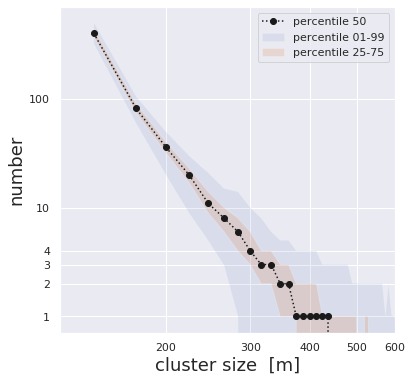

In [128]:
#--- determine the size of all clusters ---
labels, pixels = np.unique(labeled_N_ntim2.ravel(),return_counts=True)

print('pixels of largest cluster: ',max(pixels[1:]))
print('root of largest cluster number: ',max(np.sqrt(pixels[1:])))


#--- size-sort 'em --
bins_log , ind_log , CSD_log  = log_binner_minmax(        pixels[1:] ,1,150,10)
bins_lin , ind_lin , CSD_lin  = lin_binner_minmax(np.sqrt(pixels[1:]),1,15 ,14)
bins_lin2, ind_lin2, CSD_lin2 = lin_binner_minmax(        pixels[1:] ,1,40 ,39)

#print(labels)
#print(pixels)
#print(np.sqrt(pixels[1:]))

print('cloud size array, in pixels  : ',bins_lin2)
#print('cloud size density: ',CSD_lin2 )


#--- do some statistics ---

sd_size_lin_av  = np.average   ( sd_size_lin[1:,:]  , axis=0 )    #mean
print('cloud size array av, sqrt of area   : ',sd_size_lin_av)

dummy = np.where( np.isnan(sd_N_lin), 0, sd_N_lin)   #filter out nan's, set to zero

sd_N_lin_p01    = np.percentile( dummy[1:,:],  1., axis=0 )    #25% percentile
sd_N_lin_p25    = np.percentile( dummy[1:,:], 25., axis=0 )    #25% percentile
sd_N_lin_p50    = np.percentile( dummy[1:,:], 50., axis=0 )    #50% percentile
sd_N_lin_p75    = np.percentile( dummy[1:,:], 75., axis=0 )    #75% percentile
sd_N_lin_p99    = np.percentile( dummy[1:,:], 99., axis=0 )    #75% percentile


#--- percentile plot of the CSD ---
fig,ax = plt.subplots(1,1,figsize=(6,6))

#plt.plot(np.sqrt(bins_lin2[1:]),CSD_lin2,'o-',label="t=%s" % (t))

#for t in [10,100,ntim-1]:
#    plt.plot(sd_size_lin[t,:],sd_N_lin[t,:],'o-',label="t=%s" % (t))

ax.fill_between(sd_size_lin_av*dx, sd_N_lin_p01, sd_N_lin_p99, alpha=0.1,label='percentile 01-99')
ax.fill_between(sd_size_lin_av*dx, sd_N_lin_p25, sd_N_lin_p75, alpha=0.2,label='percentile 25-75')
ax.plot        (sd_size_lin_av*dx, sd_N_lin_p50, 'o:', color='k'        ,label='percentile 50')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('cluster size  [m]', fontsize=18)
ax.set_ylabel('number', fontsize=18)

ax.set_xlim([120.,600.])
ax.set_ylim([.7,700.])
plt.setp(ax.get_yticklabels(which='minor'), visible=False)   #switch off the minor tickmarks

ax.set_xticks([200,300,400,500,600])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.setp(ax.get_xticklabels(which='minor'), visible=False)   #switch off the minor tickmarks

ax.set_yticks([1,2,3,4,10,100])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.legend()
    
plt.show()                         # Show the figure

#fig.savefig('N_thermals_movie_CSD.png',bbox_inches = 'tight')
#fig.savefig('N_thermals_movie_CSD.pdf',bbox_inches = 'tight')
#
#plt.close(fig)

